Bulk objects inspection; apply GAIA->LS filter transformation

In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import sys, os, glob, time, warnings, gc

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    # plt.grid(alpha=0.5, lw=0.5)
    return ax

def binned_stats(x, y, bins):
    from scipy import stats
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    bin_median, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='median', bins=bins)
    bin_spread, _, _ = stats.binned_statistic(x, y, statistic=nmad, bins=bins)    
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_median, bin_spread

-------

In [4]:
# gaia1 and gaia2: DECaLS SGC; gaia3: BASS/MzLS
gaia_fn = 'gaia1.fits.gz'
gaia = Table.read('/Users/rongpu/Downloads/gaia_star_cutouts/'+gaia_fn)
print(len(gaia))

if (gaia_fn=='gaia1.fits.gz') or (gaia_fn=='gaia2.fits.gz'):
    mask = gaia['dec']<31.
    gaia = gaia[mask]
    print(len(gaia))
                                  
if (gaia_fn=='gaia3.fits.gz'):
    mask = gaia['dec']>32.375
    gaia = gaia[mask]
    print(len(gaia))

855294
832837


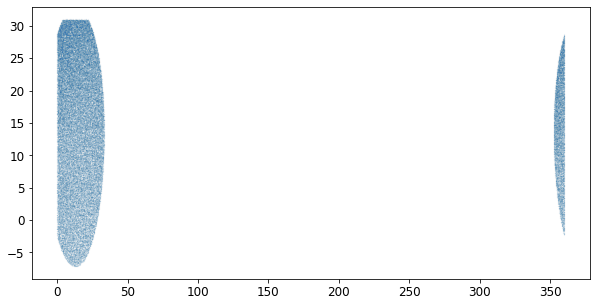

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(gaia['ra'][::10], gaia['dec'][::10], '.', ms=0.1, alpha=0.5)
plt.show()

In [6]:
# Remove duplicates
if len(np.unique(gaia['source_id']))<len(gaia):
    print('Duplicates exist!')
    gaia.sort('source_id')
    mask = gaia['source_id'][1:]==gaia['source_id'][:-1]
    mask = np.concatenate([[False], mask])
    gaia = gaia[~mask]
    
# Remove objects with invalide mask = np.isfinite(gaia['bp_rp'])
mask = np.isfinite(gaia['bp_rp'])
if np.sum(~mask)>0:
    print('{} objects with invalid bp_rp'.format(np.sum(~mask)))
    gaia = gaia[mask]

5812 objects with invalid bp_rp


In [7]:
gaia[:3]

source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_excess_noise,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val
,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mag,mag,km / s,km / s,,K,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,bytes13,float32,float32
76963928454294528,30.405325440623816,0.043583431054268214,13.590807698246374,0.03664475649931496,0.33554165612151027,0.04642950419390585,0.13216090759396082,0.09400519417895174,-3.1181403854342555,0.07185068285862767,0.06237348510707128,15.1999445,0.79629135,nan,nan,NOT_AVAILABLE,5916.0,nan
77105250058122496,31.130029533950907,0.0774492987192934,14.24676239294676,0.05998435449859614,1.8761122912295791,0.07765567241924295,16.651649895808433,0.16389922527077824,-29.872733221707904,0.1150138769657371,0.0,16.770638,1.9164085,nan,nan,NOT_AVAILABLE,3805.0,0.0298
77130912487449088,32.37128459494941,0.07443325440018038,13.434907812764257,0.06289497066991939,0.8894613198536169,0.0873026631127525,1.0491718451165948,0.1494118293145261,-3.9093751275915083,0.11921383320957166,0.13129823279539063,16.415583,1.2788982,nan,nan,NOT_AVAILABLE,4771.9053,0.3197


In [8]:
plt.hist(gaia['PHOT_G_MEAN_MAG'], 100);

KeyError: 'PHOT_G_MEAN_MAG'

In [42]:
# Apply GAIA-LS transformation
from scipy.interpolate import interp1d
transform_interp = {}
for band in ['g', 'r', 'z']:
    tmp = np.load('data/gaia_decals_{}_transform.npz'.format(band))
    bin_center, bin_median, bin_spread = tmp['arr_0'], tmp['arr_1'], tmp['arr_2']
    transform_interp[band] = interp1d(bin_center, bin_median, bounds_error=False, fill_value='extrapolate', kind='linear')
    gaia['decals_'+band] = gaia['PHOT_G_MEAN_MAG'] + transform_interp[band](gaia['BP_RP'])

In [48]:
# mask = (gaia['PHOT_G_MEAN_MAG']>16) & ((gaia['PHOT_G_MEAN_MAG']<18))
# plt.figure(figsize=(8, 8))
# plt.plot((gaia['BP_RP'])[mask], (gaia['decals_g']-gaia['PHOT_G_MEAN_MAG'])[mask], '.', ms=0.3)
# plt.xlabel('GAIA_BP - GAIA_RP')
# plt.ylabel('DECaLS_G - GAIA_G')
# plt.axis([-0.5, 3.5, -0.5, 3.])
# plt.grid(alpha=0.5)
# plt.show()

------
## Narrow bin of DECaLS g-band magnitude

/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


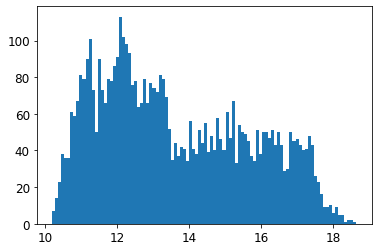

In [49]:
plt.hist(gaia['decals_g'], 100);

In [53]:
plot_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/plots/4_decals'    
band = 'g'
# img_type = '-resid'
img_type = ''
pixscale_str = '0.262'
pixscale = float(pixscale_str)
    
idx = np.where((gaia['decals_g']>12.0) & (gaia['decals_g']<12.02))[0]
print(len(idx))

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

27


/Users/rongpu/miniconda3/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/rongpu/miniconda3/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [57]:
radius_arr = []
flux_arr = []

for index in idx:

    print('PHOT_G_MEAN_MAG = ', gaia['PHOT_G_MEAN_MAG'][index])

    ra, dec = gaia['RA'][index], gaia['DEC'][index]

    download_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/'
    file_path = os.path.join(download_dir, gaia_fn[:-8], 'gaia_{}_{}{}_{}.fits'.format(index, band, img_type, pixscale_str))
    if not os.path.exists(os.path.dirname(file_path)):
        os.makedirs(os.path.dirname(file_path))
        
    if not os.path.isfile(file_path):
        url = 'http://legacysurvey.org/viewer/cutout.fits?ra={:f}&dec={:f}&layer=dr8{}&pixscale={}&bands={}'.format(ra, dec, img_type, pixscale_str, band)
        cmd = 'wget -O '+file_path+' \"'+url+'\"'
        print(cmd)
        os.system(cmd)

    img_raw = fitsio.read(file_path)
    img = img_raw / (pixscale**2)

    vrange = 0.5
    ax = plot_cutout(img, pixscale, vmin=-vrange, vmax=vrange)
    ax.set_title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['PHOT_G_MEAN_MAG'][index]))
    plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_image.png'))
    plt.close()

    grid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius = np.sqrt(xx**2 + yy**2).flatten()

    # Remove masked pixels
    mask = img.flatten()!=0
    radius = radius[mask]
    flux = img.flatten()[mask]

    bin_center, _, bin_median, bin_spread = binned_stats(radius, flux, bins=np.linspace(0., 31., 63))
    radius_arr.append(bin_center)
    flux_arr.append(bin_median)

    plt.figure(figsize=(8, 6))
    plt.plot(radius, flux, '.', ms=0.5)
    plt.plot(bin_center, bin_median, c='C1')
    plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, alpha=0.6, c='C1')
    plt.axis([0, 20, -1, 5])
    plt.axhline(0, lw=1, color='r')
    plt.grid(alpha=0.5)
    plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['PHOT_G_MEAN_MAG'][index]))
    plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile.png'))
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.loglog(radius, flux, '.', ms=0.5)
    plt.plot(bin_center, bin_median, c='C1')
    plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, alpha=0.6, c='C1')
    plt.axis([.5, 30, .02, 200])
    plt.grid(alpha=0.5)
    plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['PHOT_G_MEAN_MAG'][index]))
    plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile_log.png'))
    plt.close()

radius_arr = np.array(radius_arr)
flux_arr = np.array(flux_arr)

PHOT_G_MEAN_MAG =  11.67042
PHOT_G_MEAN_MAG =  11.2209425
PHOT_G_MEAN_MAG =  11.646951
PHOT_G_MEAN_MAG =  11.605129
PHOT_G_MEAN_MAG =  11.452733
PHOT_G_MEAN_MAG =  11.750784
PHOT_G_MEAN_MAG =  11.643083
PHOT_G_MEAN_MAG =  11.584623
PHOT_G_MEAN_MAG =  11.686535
PHOT_G_MEAN_MAG =  11.747371
PHOT_G_MEAN_MAG =  11.689386
PHOT_G_MEAN_MAG =  11.691297
PHOT_G_MEAN_MAG =  11.743011
PHOT_G_MEAN_MAG =  11.098038
PHOT_G_MEAN_MAG =  11.707091
PHOT_G_MEAN_MAG =  11.582307
PHOT_G_MEAN_MAG =  11.471519
PHOT_G_MEAN_MAG =  11.671368
PHOT_G_MEAN_MAG =  11.593182
PHOT_G_MEAN_MAG =  11.653534
PHOT_G_MEAN_MAG =  11.555827
PHOT_G_MEAN_MAG =  11.683105
PHOT_G_MEAN_MAG =  11.257183
PHOT_G_MEAN_MAG =  11.685199
PHOT_G_MEAN_MAG =  11.6937475
PHOT_G_MEAN_MAG =  11.677679
PHOT_G_MEAN_MAG =  11.593828


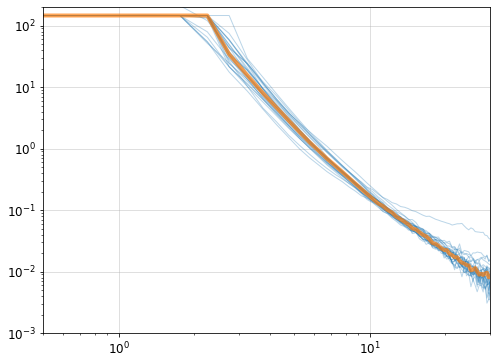

In [66]:
plt.figure(figsize=(8, 6))
plt.loglog(radius_arr.T, flux_arr.T, lw=1, alpha=0.3, c='C0')
plt.axis([.5, 30, .001, 200])
plt.grid(alpha=0.5)
x, _, y, _ = binned_stats(radius_arr.flatten(), flux_arr.flatten(), bins=np.linspace(0., 31., 63))
plt.loglog(x, y, lw=4, alpha=0.7, c='C1')
plt.show()